# Facial Expression Recognition (Image Classification)

-------------------

## Business Understanding

Facial Expression Recognition is a critical technology that is gaining traction in various industries, including healthcare, entertainment, and security. The goal of this project is to develop an accurate and efficient Facial Expression Recognition model using the PyTorch framework. The model will be trained on a large dataset of facial expressions to recognize different emotions, including happiness, sadness and neutral. 

The ultimate objective of this project is to provide businesses with a tool that can improve customer experience, increase security, and enhance overall operational efficiency. For instance, the technology can be used in healthcare to detect early signs of depression or anxiety in patients, in entertainment to enhance gaming experiences, and in security to monitor public spaces for suspicious behavior. The Facial Expression Recognition with PyTorch project has the potential to revolutionize various industries by providing an automated, accurate, and reliable tool for recognizing emotions.

---

## Understanding Dataset

The Face Expression Recognition dataset available on Kaggle contains 28,709 images of human faces, labeled with seven different facial expressions, including angry, disgust, fear, happy, sad, surprise, and neutral.

The dataset is split into two subsets, a training set of 24,706 images and a test set of 4,003 images. The images are grayscale, 48×48 pixels in size, and the data is stored in CSV format. Each row of the CSV file corresponds to an image and contains the pixel values of the image, the emotion label, and other attributes, such as the image usage and intensity.

The dataset is well-balanced, with each emotion class containing approximately the same number of images. It is important to note that the images were extracted from the FER2013 dataset and preprocessed to contain only faces with frontal pose and appropriate brightness, resulting in some loss of information.

Additionally, the dataset contains some images with low resolution or artifacts, which may affect the performance of the model.

Overall, the Face Expression Recognition dataset provides a diverse and labeled set of images for training and testing facial expression recognition models.



-------------

## Note:
     We have taken only three classes in consideration (happy, sad and nuetral) due to limited time for the project, as initial with 7 classes the models were taking too long to train on all 7 classes and were giving low accuracies.

In [32]:
# Import Packages
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
from torchsummary import summary
import torchvision.models as models

## Data Loading

Here we set up the data loader objects using images stored in folders on the local disk. Note we also set the batch size and apply a series of transforms for data augmentation.

The following class is a customized torch dataset class that allows us to specify the transform process (so we can have one transform for training and another for testing).

In [14]:
class MyLazyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [15]:
batch_size = 32

xmin_list = [0.2, 0.05, 0.2]
xmax_list = [0.45, 0.25, 0.45]

def get_data():
    data_dir_train = 'C:\\Users\\pruth\\Desktop\\facial-recognition-image-classification\\data\\train'
    data_dir_test = 'C:\\Users\\pruth\\Desktop\\facial-recognition-image-classification\\data\\validation'
   
    transform_train = transforms.Compose([
        #transforms.CenterCrop(100),
        transforms.Resize((160,160)),
        transforms.RandomInvert(0.2),
        transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.5),
        #transforms.ElasticTransform(alpha=20.0,sigma=10.0),
        #transforms.RandomPerspective(),
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

    transform_test = transforms.Compose([
        transforms.Resize((160,160)),
        transforms.ToTensor(),
        ])

    data_set_train_raw = datasets.ImageFolder(data_dir_train)
    data_set_test_raw = datasets.ImageFolder(data_dir_test)

    N_data_train = len(data_set_train_raw)
    N_data_test = len(data_set_test_raw)
    
    data_set_train = MyLazyDataset(data_set_train_raw,transform_train)
    data_set_test = MyLazyDataset(data_set_test_raw,transform_test)

    train_idx = list(range(N_data_train))
    np.random.shuffle(train_idx)
    
    test_idx = list(range(N_data_test))
    np.random.shuffle(test_idx)

    data_set_train_sub = torch.utils.data.Subset(data_set_train, indices=train_idx)
    data_set_test_sub = torch.utils.data.Subset(data_set_test, indices=test_idx)
    
    # data_set_train_sub, data_set_test_sub = torch.utils.data.random_split(dataset=data_set, lengths=[N_train, N_test], generator=torch.Generator().manual_seed(42))

    train = DataLoader(data_set_train_sub, batch_size=batch_size, shuffle=True)
    test = DataLoader(data_set_test_sub, batch_size=batch_size, shuffle=False)
 
    
    return train, test

#### Generate instances of the data loader...

In [16]:
train, test = get_data()

classes = ('happy', 'neutral', 'sad')

#### Image plotting function:

torch.Size([32, 3, 160, 160])
torch.Size([32])


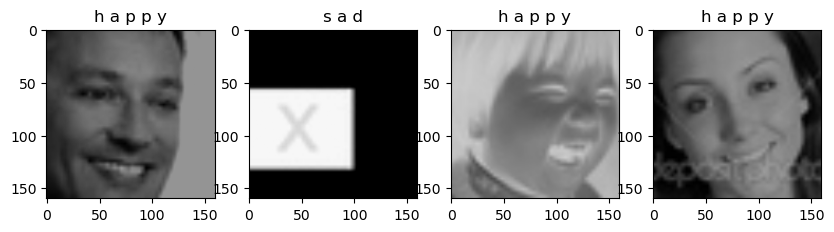

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  # This command is only applicable in my system as the system was giving out errors to show picture 

def test_imshow():
    dataiter = iter(train)
    images, labels = next(dataiter)
    print(images.shape)
    print(labels.shape)
    fig, axes = plt.subplots(figsize=(10, 8), ncols=4)
    for i in range(4):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0)) 
        ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
    plt.show()

test_imshow()

torch.Size([32, 3, 160, 160])
torch.Size([32])


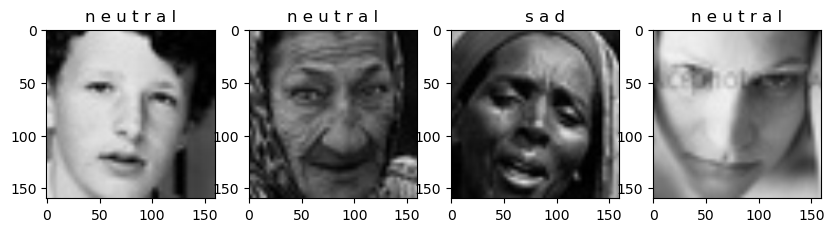

In [6]:
def test_imshow():
    dataiter = iter(test)
    images, labels = next(dataiter)
    print(images.shape)
    print(labels.shape)
    fig, axes = plt.subplots(figsize=(10, 4), ncols=4)
    for i in range(4):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0)) 
        ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
    plt.show()

test_imshow()

## Model

Let's base the model on EfficientNetB0. We'll include the option to swap out average pooling for max pooling and another option to freeze the backbone. As a default we'll assume we want to use average pooling and finetune the backbone feature layers.

In [39]:
# model = Net()
freeze_backbone = False
use_max_pooling = False

model = models.efficientnet_b0(pretrained=True)

if use_max_pooling:
    maxpools = [k.split('.') for k, m in model.named_modules() if type(m).__name__ == 'AdaptiveAvgPool2d']
    for *parent, k in maxpools:
        setattr(model.get_submodule('.'.join(parent)),'avgpool',nn.AdaptiveMaxPool2d(output_size=1))

if freeze_backbone:
    for params in model.parameters():
        params.requires_grad = False

model.classifier = nn.Sequential(
    # nn.BatchNorm1d(num_features=1536,momentum=0.95),
    nn.Linear(in_features=1280, out_features=512),
    nn.ReLU(),
    # nn.Dropout(0.3),
    # nn.BatchNorm1d(num_features=512,momentum=0.95),
    #nn.Linear(in_features=512, out_features=512),
    #nn.ReLU(),
    # nn.Dropout(0.3),
    nn.Linear(in_features=512,out_features=3),
    nn.Softmax()
)

print(model)

summary(model.cuda(),(3, 160, 160))

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 80, 80]             864
       BatchNorm2d-2           [-1, 32, 80, 80]              64
              SiLU-3           [-1, 32, 80, 80]               0
            Conv2d-4           [-1, 32, 80, 80]             288
       BatchNorm2d-5           [-1, 32, 80, 80]              64
              SiLU-6           [-1, 32, 80, 80]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 80, 80]               0
           Conv2d-13           [-1, 16, 80, 80]             512
      BatchNorm2d-14           [-1, 16,

## Training

Now we can train the network -- we'll use the Adam optimizer. Note we'll compute the accuracy based on the maximum output value, and track both accuracy and loss over each epoch. We'll also schedule learning rate decay.

In [8]:
lr = 0.0005
lr_ratio = 0.5
patience = 3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience=patience,factor=lr_ratio)

if torch.cuda.is_available(): # Checking if we can use GPU
    print("USING GPU")
    model = model.cuda()
    criterion = criterion.cuda()

USING GPU


In [9]:
def test_epoch():
    correct = 0
    total = 0
    k = 0
    loss_total = 0
    # model.eval()
    with torch.no_grad():
        for data in test:
            images, labels = data
            outputs = model(images.cuda())
            _, predicted = torch.max(outputs.data, 1)
            loss_k = criterion(outputs, labels.cuda())
            total_k = labels.size(0)
            total += total_k
            correct_k = np.sum(labels.numpy() == predicted.cpu().numpy())
            correct += correct_k
            k += 1
            loss_total += total_k*loss_k.item()

    test_accuracy = 100*correct/total
    test_loss = loss_total/total

    return test_loss, test_accuracy

In [10]:
print(len(train))

534


### Training the Model

Here we are training the model, if train_new_model is selected True it will train the model from initial, if selected false than it is picking up training from trained model(used if needed to train model on more epochs)

In [12]:
train_new_model = False
model_state_dict_filename = 'model_temp_final.pth'

k = 0

if train_new_model:

    Lp = 50

    n_epoch = 1
    kstep = 1

    epoch_loss_train = np.zeros(n_epoch)
    epoch_acc_train = np.zeros(n_epoch)
    epoch_loss_test = np.zeros(n_epoch)
    epoch_acc_test = np.zeros(n_epoch)
    epoch_learning_rate = np.zeros(n_epoch)
    acc_test_best = 0
    count = 0

    N_train_batch = len(train)

    

    for epoch in range(n_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        running_n = 0
        running_acc = 0.0

        for i, data in enumerate(train, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            if k % kstep == 0:
                optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs.cuda())
            loss = criterion(outputs, labels.cuda())
            loss.backward()

            if k % kstep == 0:
                optimizer.step()
            
            running_n += len(outputs)

            labels_pred = np.argmax(outputs.cpu().detach().numpy(),axis=1)
            # print(outputs)
            # print(labels)
            # print(labels_pred)
            # print(loss)

            # acc = np.sum(((outputs.cpu().detach().numpy()[:,0] > 0.5) == labels.numpy()))/batch_size
            acc = np.sum(labels_pred == labels.detach().numpy())
            # print statistics
            running_loss += len(outputs)*loss.item()
            running_acc += acc
            # if i % 10 == 0:  # print every 2000 mini-batches
                # print('[%d, %5d] loss: %.10f | accuracy: %.5f' %
                    #   (epoch + 1, i + 1, running_loss / running_n, 100*acc))

            p = int(Lp*((i+1)/N_train_batch))
            s = ['#']*p + ['-']*(Lp - p)
            s = "".join(s)
            print(f'epoch: {epoch:04d} | [{s}] ({int(100*(i+1)/N_train_batch):02d}%)',end='\r')

            k += 1

        loss_test, acc_test = test_epoch()
        # model.train()
        
        
        scheduler.step(acc_test)

        # if acc_test < acc_test_best:
        #     count += 1
        # else:
        #     acc_test_best = acc_test
        #     count = 0

        

        # if count >= patience:
        #     lr = lr*lr_ratio
        #     for g in optim.param_groups:
        #         g['lr'] = lr
        #     count = 0
        
        sched_lr = optimizer.param_groups[0]['lr']

        print(f'epoch: {epoch:04d} | training loss = {running_loss/running_n:0.4f} | training accuracy = {100*running_acc/running_n:0.1f} | test loss = {loss_test:0.4f} | test accuracy = {acc_test:0.1f} | count = {count} | learning rate = {sched_lr}')
        
        epoch_loss_train[epoch] = running_loss/running_n
        epoch_acc_train[epoch] = 100*running_acc/running_n
        epoch_loss_test[epoch] = loss_test
        epoch_acc_test[epoch] = acc_test
        epoch_learning_rate[epoch] = sched_lr
        
    torch.save(model.state_dict(), 'model_temp_final.pth')

else:
    model.load_state_dict(torch.load(model_state_dict_filename))
    
    
    Lp = 50

    n_epoch = 10
    kstep = 1

    epoch_loss_train = np.zeros(n_epoch)
    epoch_acc_train = np.zeros(n_epoch)
    epoch_loss_test = np.zeros(n_epoch)
    epoch_acc_test = np.zeros(n_epoch)
    epoch_learning_rate = np.zeros(n_epoch)
    acc_test_best = 0
    count = 0

    N_train_batch = len(train)

    

    for epoch in range(n_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        running_n = 0
        running_acc = 0.0

        for i, data in enumerate(train, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            if k % kstep == 0:
                optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs.cuda())
            loss = criterion(outputs, labels.cuda())
            loss.backward()

            if k % kstep == 0:
                optimizer.step()
            
            running_n += len(outputs)

            labels_pred = np.argmax(outputs.cpu().detach().numpy(),axis=1)
            # print(outputs)
            # print(labels)
            # print(labels_pred)
            # print(loss)

            # acc = np.sum(((outputs.cpu().detach().numpy()[:,0] > 0.5) == labels.numpy()))/batch_size
            acc = np.sum(labels_pred == labels.detach().numpy())
            # print statistics
            running_loss += len(outputs)*loss.item()
            running_acc += acc
            # if i % 10 == 0:  # print every 2000 mini-batches
                # print('[%d, %5d] loss: %.10f | accuracy: %.5f' %
                    #   (epoch + 1, i + 1, running_loss / running_n, 100*acc))

            p = int(Lp*((i+1)/N_train_batch))
            s = ['#']*p + ['-']*(Lp - p)
            s = "".join(s)
            print(f'epoch: {epoch:04d} | [{s}] ({int(100*(i+1)/N_train_batch):02d}%)',end='\r')

            k += 1

        loss_test, acc_test = test_epoch()
        # model.train()
        
        
        scheduler.step(acc_test)

        # if acc_test < acc_test_best:
        #     count += 1
        # else:
        #     acc_test_best = acc_test
        #     count = 0

        

        # if count >= patience:
        #     lr = lr*lr_ratio
        #     for g in optim.param_groups:
        #         g['lr'] = lr
        #     count = 0
        
        sched_lr = optimizer.param_groups[0]['lr']

        print(f'epoch: {epoch:04d} | training loss = {running_loss/running_n:0.4f} | training accuracy = {100*running_acc/running_n:0.1f} | test loss = {loss_test:0.4f} | test accuracy = {acc_test:0.1f} | count = {count} | learning rate = {sched_lr}')
        
        epoch_loss_train[epoch] = running_loss/running_n
        epoch_acc_train[epoch] = 100*running_acc/running_n
        epoch_loss_test[epoch] = loss_test
        epoch_acc_test[epoch] = acc_test
        epoch_learning_rate[epoch] = sched_lr
        
    torch.save(model.state_dict(), 'model_temp_final.pth')


epoch: 0000 | training loss = 0.6600 | training accuracy = 88.9 | test loss = 0.7577 | test accuracy = 79.0 | count = 0 | learning rate = 0.0005
epoch: 0001 | training loss = 0.6724 | training accuracy = 87.6 | test loss = 0.7540 | test accuracy = 79.2 | count = 0 | learning rate = 0.0005
epoch: 0002 | training loss = 0.6722 | training accuracy = 87.7 | test loss = 0.7677 | test accuracy = 77.8 | count = 0 | learning rate = 0.0005
epoch: 0003 | training loss = 0.6782 | training accuracy = 87.2 | test loss = 0.7571 | test accuracy = 79.1 | count = 0 | learning rate = 0.0005
epoch: 0004 | training loss = 0.6622 | training accuracy = 88.7 | test loss = 0.7582 | test accuracy = 78.9 | count = 0 | learning rate = 0.0005
epoch: 0005 | training loss = 0.6585 | training accuracy = 89.1 | test loss = 0.7578 | test accuracy = 79.0 | count = 0 | learning rate = 0.00025
epoch: 0006 | training loss = 0.6490 | training accuracy = 90.1 | test loss = 0.7516 | test accuracy = 79.7 | count = 0 | learnin

It only shows 10 epochs as this is part of the continue training on model.

The model have been train on total of 50 epochs.

----

## Plot training and testing accuracy



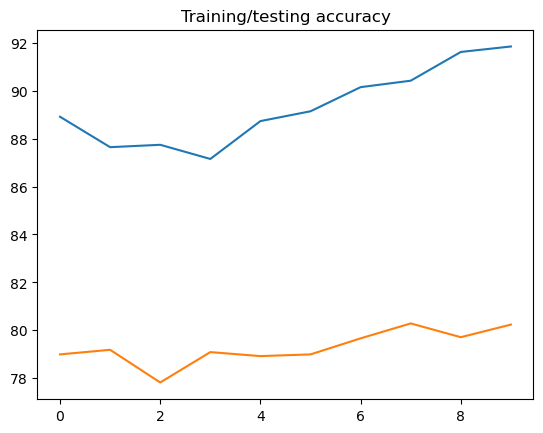

In [13]:
#if train_new_model:
fig, ax = plt.subplots()
ax.plot(np.arange(0,n_epoch), epoch_acc_train, np.arange(0,n_epoch), epoch_acc_test)
ax.set_title('Training/testing accuracy')
plt.show()

As seen the model testing accuracy is not going over 80 percent where the training accuracy is going over 90, this is sign of overfitting as testing accuracy is stuck at 80 percent, however it is still considerable testing accuracy

-----

## Plot training and testing loss

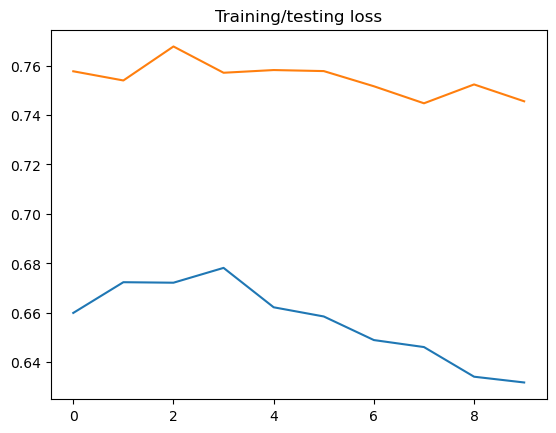

In [14]:
#if train_new_model:
fig, ax = plt.subplots()
ax.plot(np.arange(0,n_epoch), epoch_loss_train, np.arange(0,n_epoch), epoch_loss_test)
ax.set_title('Training/testing loss')
plt.show()

## Run a final evaluation on the testing data

In [17]:
correct = 0
total = 0
k = 0
loss_total = 0

y = []
y_pred = []

print(y)
print(y_pred)

# model.eval()
with torch.no_grad():
    for data in test:
        images, labels = data

        y += labels.numpy().tolist()

        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)

        y_pred += predicted.cpu().numpy().tolist()

        loss_k = criterion(outputs, labels.cuda())
        total_k = labels.size(0)
        total += total_k
        correct_k = np.sum(labels.numpy() == predicted.cpu().numpy())
        correct += correct_k
        k += 1
        loss_total += total_k*loss_k.item()

test_accuracy = 100*correct/total
test_loss = loss_total/total

print(test_accuracy)
print(correct)
print(total)

[]
[]


C:\Users\pruth\anaconda3\Lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


80.50239234449761
3365
4180


Running a final evaluation on the model, as seen we have 80.5 percent accuracy on the testing data

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y,y_pred)

array([[1629,  103,   93],
       [  92,  894,  230],
       [  53,  261,  825]], dtype=int64)

### Loading the model and running the predictions and creating a confusion matrix heatmap

In [40]:
import torch
import torchvision.transforms as transforms


# Load the saved model checkpoint
#model = models.efficientnet_b0(pretrained=True)  # Replace with your model class
#model = model.load_state_dict(torch.load('model_temp_final.pth'))
model.load_state_dict(torch.load('model_temp_final.pth'))
model.eval()
#model.eval()

if torch.cuda.is_available():
    model = model.to('cuda')

correct = 0
total = 0
k = 0
loss_total = 0

y = []
y_pred = []

print(y)
print(y_pred)

# model.eval()
with torch.no_grad():
    for data in test:
        images, labels = data

        y += labels.numpy().tolist()

        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)

        y_pred += predicted.cpu().numpy().tolist()

        loss_k = criterion(outputs, labels.cuda())
        total_k = labels.size(0)
        total += total_k
        correct_k = np.sum(labels.numpy() == predicted.cpu().numpy())
        correct += correct_k
        k += 1
        loss_total += total_k*loss_k.item()

test_accuracy = 100*correct/total
test_loss = loss_total/total

print(test_accuracy)
print(correct)
print(total)

[]
[]
80.7177033492823
3374
4180


In [41]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y,y_pred)

array([[1643,   97,   85],
       [  87,  900,  229],
       [  47,  261,  831]], dtype=int64)

              precision    recall  f1-score   support

       happy       0.92      0.90      0.91      1825
     neutral       0.72      0.74      0.73      1216
         sad       0.73      0.73      0.73      1139

    accuracy                           0.81      4180
   macro avg       0.79      0.79      0.79      4180
weighted avg       0.81      0.81      0.81      4180



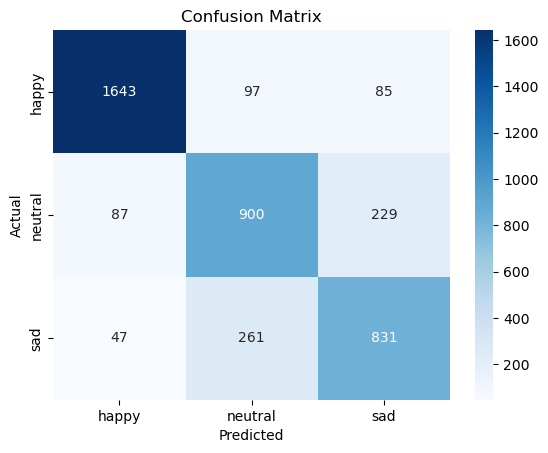

In [49]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Create a confusion matrix heatmap with class labels
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)

# Generate a classification report
true_labels = y  # Replace with your actual true labels
predicted_labels = y_pred  # Replace with your actual predicted labels

print(classification_report(true_labels, predicted_labels, target_names=classes))

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

As seen from the precision and confusion matrix, the model is performing very well with class: Happy, and have 70 percent precision with both Neutral and Sad, as it is understandable that the facial features are similar with both the expression